# Audio Copy-Move Forgery Detection Using Deep Learning

This project focuses on audio copy-move forgery detection using a graph-based image classification approach. It converts audio signals into high-resolution spectrograms, identifies duplicated segments using keypoint matching and swarm-based optimization, and then transforms the filtered audio into a graph representation. A CNN model is used to classify the graph images and detect forgeries with high accuracy. The method is designed to be robust against various attacks and scalable for different datasets.

## Importing Packages

In [7]:
import os
import numpy as np
import pandas as pd
import librosa
import cv2
import networkx as nx
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RegularGridInterpolator
from pyswarm import pso
from tensorflow.keras.utils import Sequence
import joblib
import multiprocessing
from functools import partial
import community as community_louvain
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

## Super-Resolution Spectrogram Generation

In [8]:
def load_audio(file_path, sr=22050, duration=10):
    """
    Load audio file with specified sample rate and duration limit.
    """
    try:
        audio, sample_rate = librosa.load(file_path, sr=sr, duration=duration)
        return audio, sample_rate
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.zeros(sr), sr

def compute_stft(audio, sr, window_size, hop_length):
    """
    Compute Short-Time Fourier Transform of audio signal.
    """
    stft = librosa.stft(audio, n_fft=window_size, hop_length=hop_length)
    return np.abs(stft)

def generate_super_resolution_spectrogram(audio, sr, short_window=256, long_window=1024, hop_length=128):
    """
    Generate super-resolution spectrogram.
    """
    # Compute spectrograms with different window sizes
    V_t = compute_stft(audio, sr, short_window, hop_length)
    V_f = compute_stft(audio, sr, long_window, hop_length)

    # Make sure both spectrograms have the same time dimension
    min_time = min(V_t.shape[1], V_f.shape[1])
    V_t = V_t[:, :min_time]
    V_f = V_f[:, :min_time]

    # Create coordinate arrays
    freq_t = np.linspace(0, 1.0, V_t.shape[0])
    freq_f = np.linspace(0, 1.0, V_f.shape[0])
    time_points = np.linspace(0, 1.0, min_time)

    # Create the interpolation function
    points = (freq_t, time_points)
    interp_func = RegularGridInterpolator(points, V_t, method='linear',
                                         bounds_error=False, fill_value=0)

    # Create target points for interpolation
    freq_mesh, time_mesh = np.meshgrid(freq_f, time_points, indexing='ij')
    points_new = np.vstack([freq_mesh.ravel(), time_mesh.ravel()]).T # The vstack is a vertical stack meaning it adds along x axis and the .T is for Transpose

    # Interpolate and reshape
    V_t_resized = interp_func(points_new).reshape(V_f.shape)

    # Applying simple averaging instead of full PHCA
    V_super = (V_t_resized + V_f) / 2

    return V_super

## Keypoints Extraction

In [13]:
def extract_and_match_keypoints(spectrogram):
    """
    Extract and match keypoints in a spectrogram using SIFT .
    """
    # Downsampling very large spectrograms
    max_dim = 1000
    if spectrogram.shape[0] > max_dim or spectrogram.shape[1] > max_dim:
        scale = max_dim / max(spectrogram.shape[0], spectrogram.shape[1])
        new_shape = (int(spectrogram.shape[1] * scale), int(spectrogram.shape[0] * scale))
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
        img = np.uint8(255 * (spectrogram_db - spectrogram_db.min()) /
                      (spectrogram_db.max() - spectrogram_db.min() + 1e-10))
        img = cv2.resize(img, new_shape)
    else:
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
        img = np.uint8(255 * (spectrogram_db - spectrogram_db.min()) /
                      (spectrogram_db.max() - spectrogram_db.min() + 1e-10))

    sift = cv2.SIFT_create(nfeatures=500)
    keypoints, descriptors = sift.detectAndCompute(img, None)

    # Handle case with no keypoints
    if descriptors is None or len(keypoints) < 2:
        return [], [], img

    if len(keypoints) > 200:
        keypoints = keypoints[:200]
        descriptors = descriptors[:200]

    matches = []
    for i in range(len(keypoints)):
        for j in range(i+1, len(keypoints)):
            dist = np.linalg.norm(descriptors[i] - descriptors[j]) 
            if dist < 200:
                match = cv2.DMatch()
                match.queryIdx = i
                match.trainIdx = j
                match.distance = dist
                matches.append(match)
                if len(matches) >= 200:
                    break
        if len(matches) >= 200:
            break

    good_matches = matches[:200]

    return keypoints, good_matches, img

## Frequency Range Determination

In [14]:
def determine_frequency_range(spectrogram, keypoints, matches, max_iter=10):
    """
    Determine optimal frequency range.
    """
    if not matches or len(matches) < 2:
        freq_bins = np.linspace(0, 22050 // 2, spectrogram.shape[0])
        return freq_bins[0], freq_bins[-1]

    else:
        src_pts = np.float32([keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 2)

        if len(src_pts) > 0:
            hist, bin_edges = np.histogram(src_pts[:, 1], bins=10)
            max_bin = np.argmax(hist)

            total_freq = 22050 // 2
            bin_size = spectrogram.shape[0] / 10
            f_start = (bin_edges[max_bin] / spectrogram.shape[0]) * total_freq
            f_end = (bin_edges[max_bin+1] / spectrogram.shape[0]) * total_freq

            f_start = max(0, f_start - 500)
            f_end = min(total_freq, f_end + 500)

            return f_start, f_end

    freq_bins = np.linspace(0, 22050 // 2, spectrogram.shape[0])
    return freq_bins[0], freq_bins[-1]

## Bandpass Filter

In [15]:
def bandpass_filter_audio(audio, sr, f_start, f_end, order=2):
    """
    Apply bandpass filter to audio signal.
    """
    nyquist = sr / 2
    f_start = max(20, min(f_start, nyquist - 100))
    f_end = max(f_start + 100, min(f_end, nyquist - 20))

    low = f_start / nyquist
    high = f_end / nyquist

    try:
        b, a = signal.butter(order, [low, high], btype='band') # For noise reduction
        filtered_audio = signal.lfilter(b, a, audio) # Linear filter
    except Exception:
        b, a = signal.butter(order, [0.1, 0.9], btype='band')
        filtered_audio = signal.lfilter(b, a, audio)

    return filtered_audio

## Graph Generation

In [16]:
def spiral_pattern_extraction(audio, frame_size=8, max_nodes=200):
    """
    Extract spiral patterns from audio frames.
    """
    # limit the number of frames processed (My System couldn't process that is why reducing frames)
    hop_length = max(frame_size * 8, len(audio) // max_nodes)

    if len(audio) < frame_size:
        padded_audio = np.pad(audio, (0, frame_size - len(audio))) # Adding Extra elements in the array
        frames = np.array([padded_audio])
    else:
        frames = librosa.util.frame(audio, frame_length=frame_size, hop_length=hop_length).T

    frames = frames[:max_nodes]

    # Simplified pattern extraction (just using raw values)
    spiral_values = []
    for frame in frames:
        mean_val = np.mean(frame)
        std_val = np.std(frame)
        spiral_values.append(mean_val + std_val)

    return np.array(spiral_values)

def generate_visibility_graph(spiral_values, max_connections=5):
    """
    Generate visibility graph with aggressive edge pruning.
    """
    G = nx.Graph()
    n = min(len(spiral_values), 200)

    if n < 2:
        G.add_node(0, value=0)
        return G, {0: 0}

    spiral_values = spiral_values[:n].astype(float)
    for i, v in enumerate(spiral_values):
        G.add_node(i, value=v)

    # Simplified edge creation - just connect sequential points and a few others
    for a in range(n):
        # Connect to next few points
        for b in range(a + 1, min(a + max_connections + 1, n)):
            G.add_edge(a, b, weight=1.0)

        # Add a few longer-range connections
        if a % 5 == 0 and a + 10 < n:
            G.add_edge(a, a + 10, weight=0.5)

    # Community detection
    try:
        # Limit iterations for faster processing
        partition = community_louvain.best_partition(G, resolution=1.0, randomize=False)
    except Exception:
        partition = {i: i % 5 for i in G.nodes()}

    return G, partition

def graph_to_image(G, partition, size=(240, 320), min_node_size=2, max_node_size=6):
    """
    Convert graph to image representation with drawing operations.
    """
    img = np.zeros((*size, 3), dtype=np.uint8)

    if len(G.nodes()) == 0:
        return img
        
    try:
        pos = {node: (0.5 + 0.4 * np.cos(node * 0.1), 0.5 + 0.4 * np.sin(node * 0.1))
              for node in G.nodes()}
    except Exception:
        pos = {node: (np.random.random(), np.random.random()) for node in G.nodes()}

    # Simplified node sizing
    if len(G.nodes()) > 1:
        degrees = dict(G.degree())
        max_degree = max(degrees.values()) if degrees else 1
        min_degree = min(degrees.values()) if degrees else 0
        range_degree = max_degree - min_degree or 1
    else:
        degrees = {list(G.nodes())[0]: 1}
        range_degree = 1
        min_degree = 0

    # Draw nodes
    for node, color in partition.items():
        if node in pos:
            x, y = pos[node]
            x = int(x * size[1])
            y = int(y * size[0])

            if 0 <= x < size[1] and 0 <= y < size[0]:
                # Set node size based on degree
                if node in degrees:
                    node_size = int(min_node_size +
                                  (degrees[node] - min_degree) / range_degree *
                                  (max_node_size - min_node_size))
                else:
                    node_size = min_node_size

                # Simple color based on community
                color_value = [
                    color * 35 % 255,  # R
                    color * 75 % 255,  # G
                    color * 125 % 255  # B
                ]

                cv2.circle(img, (x, y), node_size, color_value, -1)

    # Draw edges (limit to save time)
    edge_count = 0
    for u, v in G.edges():
        if edge_count > 300:  # Limit edges drawn
            break

        if u in pos and v in pos:
            x1, y1 = pos[u]
            x2, y2 = pos[v]

            x1 = int(x1 * size[1])
            y1 = int(y1 * size[0])
            x2 = int(x2 * size[1])
            y2 = int(y2 * size[0])

            if (0 <= x1 < size[1] and 0 <= y1 < size[0] and
                0 <= x2 < size[1] and 0 <= y2 < size[0]):

                cv2.line(img, (x1, y1), (x2, y2), (150, 150, 150), 1)
                edge_count += 1

    return img

## CNN Model

In [17]:
def build_cnn(input_shape=(240, 320, 3), learning_rate=0.0001):
    """
    Build lightweight CNN model with fine-tuning for forgery detection.
    """
    base_model = tf.keras.applications.MobileNetV2(  # loading a pretrained Base Model
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = True # Setting Base Model as Trainable
    
    for layer in base_model.layers[:100]:  # Freeze first 100 layers
        layer.trainable = False

    model = models.Sequential([  # Creates a sequential model
        tf.keras.Input(shape=input_shape), 

        # Data Augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),  # Light augmentation

        # Pretrained Model
        base_model,

        # Global Average Pooling
        layers.GlobalAveragePooling2D(),

        # Fullly Connected Layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])

    # Compiling Model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Optimization
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## Audio Processing

In [18]:
def process_audio(file_path, debug=False):
    """
    Process audio file to generate mel-spectrogram.
    """
    try:
        audio, sr = load_audio(file_path, duration=10)
        if np.random.random() < 0.5:
            audio += np.random.randn(len(audio)) * 0.005  # Add noise
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, hop_length=512)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        img = cv2.resize(mel_spec_db, (320, 240))  # Match input shape
        img = (img - img.min()) / (img.max() - img.min() + 1e-10) * 255  # Normalize
        return np.stack([img, img, img], axis=-1)  # 3-channel image
    except Exception as e:
        if debug:
            print(f"Error processing {file_path}: {e}")
        return np.zeros((240, 320, 3), dtype=np.uint8)

# Process audio files in parallel
def process_audio_files_batch(file_paths, output_dir, max_workers=None):
    os.makedirs(output_dir, exist_ok=True)

    # Determine optimal number of workers based on CPU cores
    if max_workers is None:
        max_workers = max(1, multiprocessing.cpu_count() - 1)

    results = []

    # Process files in batches to avoid memory issues
    batch_size = 100
    total_batches = (len(file_paths) + batch_size - 1) // batch_size

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(file_paths))
        batch_files = file_paths[start_idx:end_idx]

        print(f"Processing batch {batch_idx+1}/{total_batches} ({len(batch_files)} files)")

        with multiprocessing.Pool(processes=max_workers) as pool:
            for i, file_path in enumerate(tqdm(batch_files)):
                file_idx = start_idx + i
                output_path = os.path.join(output_dir, f"graph_{file_idx}.png")

                # Skip if already processed
                if os.path.exists(output_path):
                    results.append(output_path)
                    continue

                # Process audio and save image
                graph_img = process_audio(file_path)
                cv2.imwrite(output_path, graph_img)
                results.append(output_path)

    return results

## Data generator for pre-processed images

In [19]:
class EfficientAudioDataGenerator(Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, preprocessed_dir=None,
                 base_dir=None, process_on_demand=True, **kwargs):
        super().__init__(**kwargs)
        self.df = df.copy()
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.base_dir = base_dir
        self.preprocessed_dir = preprocessed_dir
        self.process_on_demand = process_on_demand
        self.file_indices = {row['filename']: i for i, (_, row) in enumerate(df.iterrows())}
        self.on_epoch_end()

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.df))
        batch_df = self.df.iloc[start_idx:end_idx]

        X_batch, y_batch = [], []
        for _, row in batch_df.iterrows():
            filename = row['filename']
            file_idx = self.file_indices.get(filename, 0)
            img_path = os.path.join(self.preprocessed_dir, f"mel_{file_idx}.png") if self.preprocessed_dir else None

            if self.preprocessed_dir and os.path.exists(img_path):
                img = cv2.imread(img_path)
                if img is None:
                    img = process_audio(os.path.join(self.base_dir, filename))
            else:
                img = process_audio(os.path.join(self.base_dir, filename))
                if self.preprocessed_dir and self.process_on_demand:
                    os.makedirs(self.preprocessed_dir, exist_ok=True)
                    cv2.imwrite(img_path, img)

            X_batch.append(img / 255.0)  # Normalize to [0, 1]
            y_batch.append(row['class_id'])

        return np.array(X_batch), np.array(y_batch)

    def __len__(self):
        """Number of batches per epoch."""
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch."""
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

## Constructing the Pipeline for model training

Loaded 1000 audio files from metadata.
Class distribution: class_id
0    0.5
1    0.5
Name: proportion, dtype: float64
Train: 700, Val: 150, Test: 150


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 240, 320, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 240, 320, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 10, 1280)    │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 2,025,666 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.4889 - loss: 0.8778 - val_accuracy: 0.5067 - val_loss: 0.7918 - learning_rate: 1.0000e-04
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.5445 - loss: 0.7210 - val_accuracy: 0.5133 - val_loss: 0.7806 - learning_rate: 1.0000e-04
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.5440 - loss: 0.7345 - val_accuracy: 0.5000 - val_loss: 1.0110 - learning_rate: 1.0000e-04
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5832 - loss: 0.6800 - val_accuracy: 0.5000 - val_loss: 1.0724 - learning_rate: 1.0000e-04
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6326 - loss: 0.6550 - val_accuracy: 0.5000 - val_loss: 1.0345 - learning_rate: 1.0000e-04
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6011 - loss: 0.6656 - val_accuracy: 0.5000 - val_loss: 1.0216 - learning_rate: 5.0000e-05
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6171 - loss:

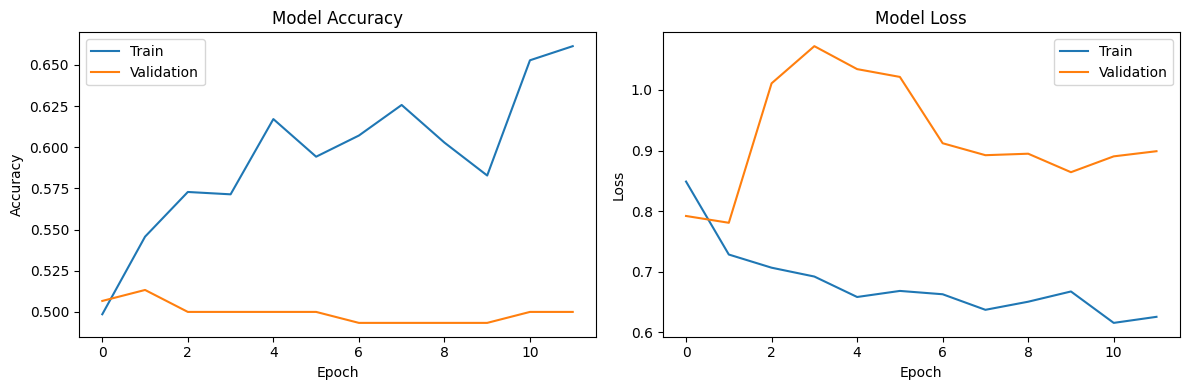

In [22]:
def main(preprocess=True):
    base_dir = "/home/pavan-kumar/pavan/audio-copy-forgery-detection/Dataset/p1_p2combined"
    metadata_path = f"{base_dir}/metadata.csv"
    preprocessed_dir = "images/"
    os.makedirs(preprocessed_dir, exist_ok=True)

    df = pd.read_csv(metadata_path).iloc[:1000] # Loading the Dataset
    print(f"Loaded {len(df)} audio files from metadata.")
    print("Class distribution:", df['class_id'].value_counts(normalize=True))

    # Split data
    train_df, temp_df = train_test_split(df, train_size=0.7, stratify=df['class_id'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class_id'], random_state=42)
    print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    # Pre-process sequentiall
    if preprocess:
        print("Pre-processing audio files...")
        for i, row in enumerate(tqdm(df.iterrows(), total=len(df))):
            file_path = os.path.join(base_dir, row[1]['filename'])
            img = process_audio(file_path)
            cv2.imwrite(os.path.join(preprocessed_dir, f"mel_{i}.png"), img)

    # Data generators
    batch_size = 32
    train_gen = EfficientAudioDataGenerator(train_df, batch_size, True, preprocessed_dir, base_dir)
    val_gen = EfficientAudioDataGenerator(val_df, batch_size, False, preprocessed_dir, base_dir)
    test_gen = EfficientAudioDataGenerator(test_df, batch_size, False, preprocessed_dir, base_dir)

    # Build and train model
    model = build_cnn(input_shape=(240, 320, 3), learning_rate=0.0001)
    model.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = model.fit(
        train_gen,
        epochs=30,
        validation_data=val_gen,
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Evaluate and diagnose
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Diagnostics
    y_true = test_df['class_id'].values
    y_pred = np.argmax(model.predict(test_gen), axis=1)
    from sklearn.metrics import confusion_matrix, classification_report
    print("Confusion Matrix:\n", confusion_matrix(y_true[:len(y_pred)], y_pred))
    print("Classification Report:\n", classification_report(y_true[:len(y_pred)], y_pred, target_names=['Genuine', 'Forged']))

    # Save model
    joblib.dump(model, 'forgery_detector.joblib')
    print("Model saved as 'forgery_detector.joblib'")

    # Plot training history (unchanged)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    print("Training history saved as 'training_history.png'")

    
if __name__ == "__main__":
    main(preprocess=False)

## Testing the Model

Model loaded successfully.
Predicted Class: Genuine
Graph image saved as 'test_graph_image.png'


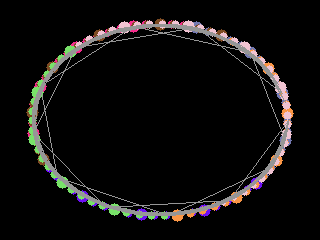

In [27]:
import numpy as np
import cv2
import joblib
import librosa

# Load the saved model
model = joblib.load('audio_forgery_detection_model.joblib')
print("Model loaded successfully.")

# Define the function to process a single audio file
def test(file_path, max_pso_iter=10, debug=False):
    try:
        audio, sr = load_audio(file_path, duration=10)
        V_super = generate_super_resolution_spectrogram(audio, sr)
        keypoints, matches, img = extract_and_match_keypoints(V_super)
        if len(matches) > 5:
            f_start, f_end = determine_frequency_range(V_super, keypoints, matches, max_iter=max_pso_iter)
            filtered_audio = bandpass_filter_audio(audio, sr, f_start, f_end)
        else:
            filtered_audio = audio
        spiral_values = spiral_pattern_extraction(filtered_audio, max_nodes=200)
        G, partition = generate_visibility_graph(spiral_values, max_connections=5)
        graph_img = graph_to_image(G, partition)
        return graph_img
    except Exception as e:
        if debug:
            print(f"Error processing {file_path}: {e}")
        return np.zeros((240, 320, 3), dtype=np.uint8)

# Path to your audio file
audio_file_path = "/home/pavan-kumar/pavan/audio-copy-forgery-detection/Dataset/p1_g01_f1_1_t-b0656_original.wav"

# Process the audio file to get the graph image
graph_img = test(audio_file_path, debug=True)

# Prepare the image for prediction (add batch dimension)
graph_img = np.expand_dims(graph_img, axis=0)  # Shape: (1, 240, 320, 3)

# Make prediction
def audio_to_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=22050, duration=10)
    y = librosa.util.fix_length(y, size=int(22050 * 10))
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfcc.flatten()

mfcc_flat = audio_to_mfcc(audio_file_path)
X_test = np.array([mfcc_flat])
predictions = model.predict(X_test)
predicted_class = predictions[0]

# Interpret the result (assuming class_id 0 = genuine, 1 = forged)
class_names = {0: "Genuine", 1: "Forged"}
print(f"Predicted Class: {class_names[predicted_class]}")

# Optionally, save the graph image for inspection
cv2.imwrite("test_graph_image.png", graph_img[0])
print("Graph image saved as 'test_graph_image.png'")

from IPython.display import Image
Image(filename='test_graph_image.png') 